In [1]:
import pandas as pd
from enrichr import enrichr
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

In [2]:
#chemicals found in Amla with known target
chem_list = pd.read_csv('data/chemical_target_experiment.csv').merge(
    pd.read_csv('data/Gooseberry_chemical_list.csv')[['chemName', 'class']],
    on='chemName', how='left'
)

In [3]:
chem_list['class'].value_counts()

Flavonoids                             82
Tannins                                47
Dihydrofurans                          29
Carboxylic acids and derivatives       15
Phenols                                 5
Benzene and substituted derivatives     5
Name: class, dtype: int64

In [4]:
#run pathway enrichement with enrichr
path_df = enrichr(chem_list.groupby('class')['GeneId'].apply(set).reset_index().rename(
    columns={'class':'set', 'GeneId':'genes'}), lib='Reactome_2022')
path_df = path_df[path_df.adj_p_value < 0.01].copy()

In [5]:
path_df['pathwayId'] = path_df.set_B.apply(lambda x: x.split()[-1])

In [6]:
#reactome pathways annotated at the lower level
reactome = pd.read_csv('data/pathway_gene_associations.csv')
llpath = reactome[reactome.degree_in_tree == 1].pathwayId.unique()

In [7]:
path_sel = path_df[path_df.pathwayId.isin(llpath)]

In [8]:
#enriched pathways per class
path_sel.groupby('set_A')['pathwayId'].size()

set_A
Carboxylic acids and derivatives    14
Dihydrofurans                        2
Flavonoids                          38
Phenols                              5
Tannins                             18
Name: pathwayId, dtype: int64

In [9]:
path_sel.set_B.nunique()

66

In [10]:
reactome[reactome.pathwayId.isin(path_sel.pathwayId.unique())].groupby('pathwayName')['GeneId'].size().sort_values(ascending=False)

pathwayName
FCGR3A-mediated phagocytosis                       142
FCGR3A-mediated IL10 synthesis                     121
Interleukin-4 and Interleukin-13 signaling         112
PI5P, PP2A and IER3 Regulate PI3K/AKT Signaling    106
FCGR activation                                     94
                                                  ... 
Estrogen biosynthesis                                6
Biosynthesis of E-series 18(S)-resolvins             5
Organic anion transport                              5
Disinhibition of SNARE formation                     5
Abacavir transmembrane transport                     5
Name: GeneId, Length: 66, dtype: int64

In [11]:
path_sel = path_sel.merge(
    pd.read_csv('data/pathway_gene_associations.csv').groupby('pathwayId')['GeneId'].apply(set).reset_index(),
    on='pathwayId', how='left'
    ).rename(columns={'GeneId': 'path_genes', 'set_A':'class'}).merge(
        chem_list.groupby('class')['GeneId'].apply(set).reset_index(), 
        on='class', how='left'
    ).rename(columns={'GeneId': 'class_genes'})

In [12]:
def f(x): return( len(x[4] & x[5])/len(x[4]) * 100)
path_sel['coverage'] = path_sel.apply(f, axis=1)

In [13]:
path_sel['set_B'] = path_sel.set_B.apply(lambda x: x.split('R-HSA-')[0])

(0.0, 87.50000000000001, -0.4, 65.39999999999999)

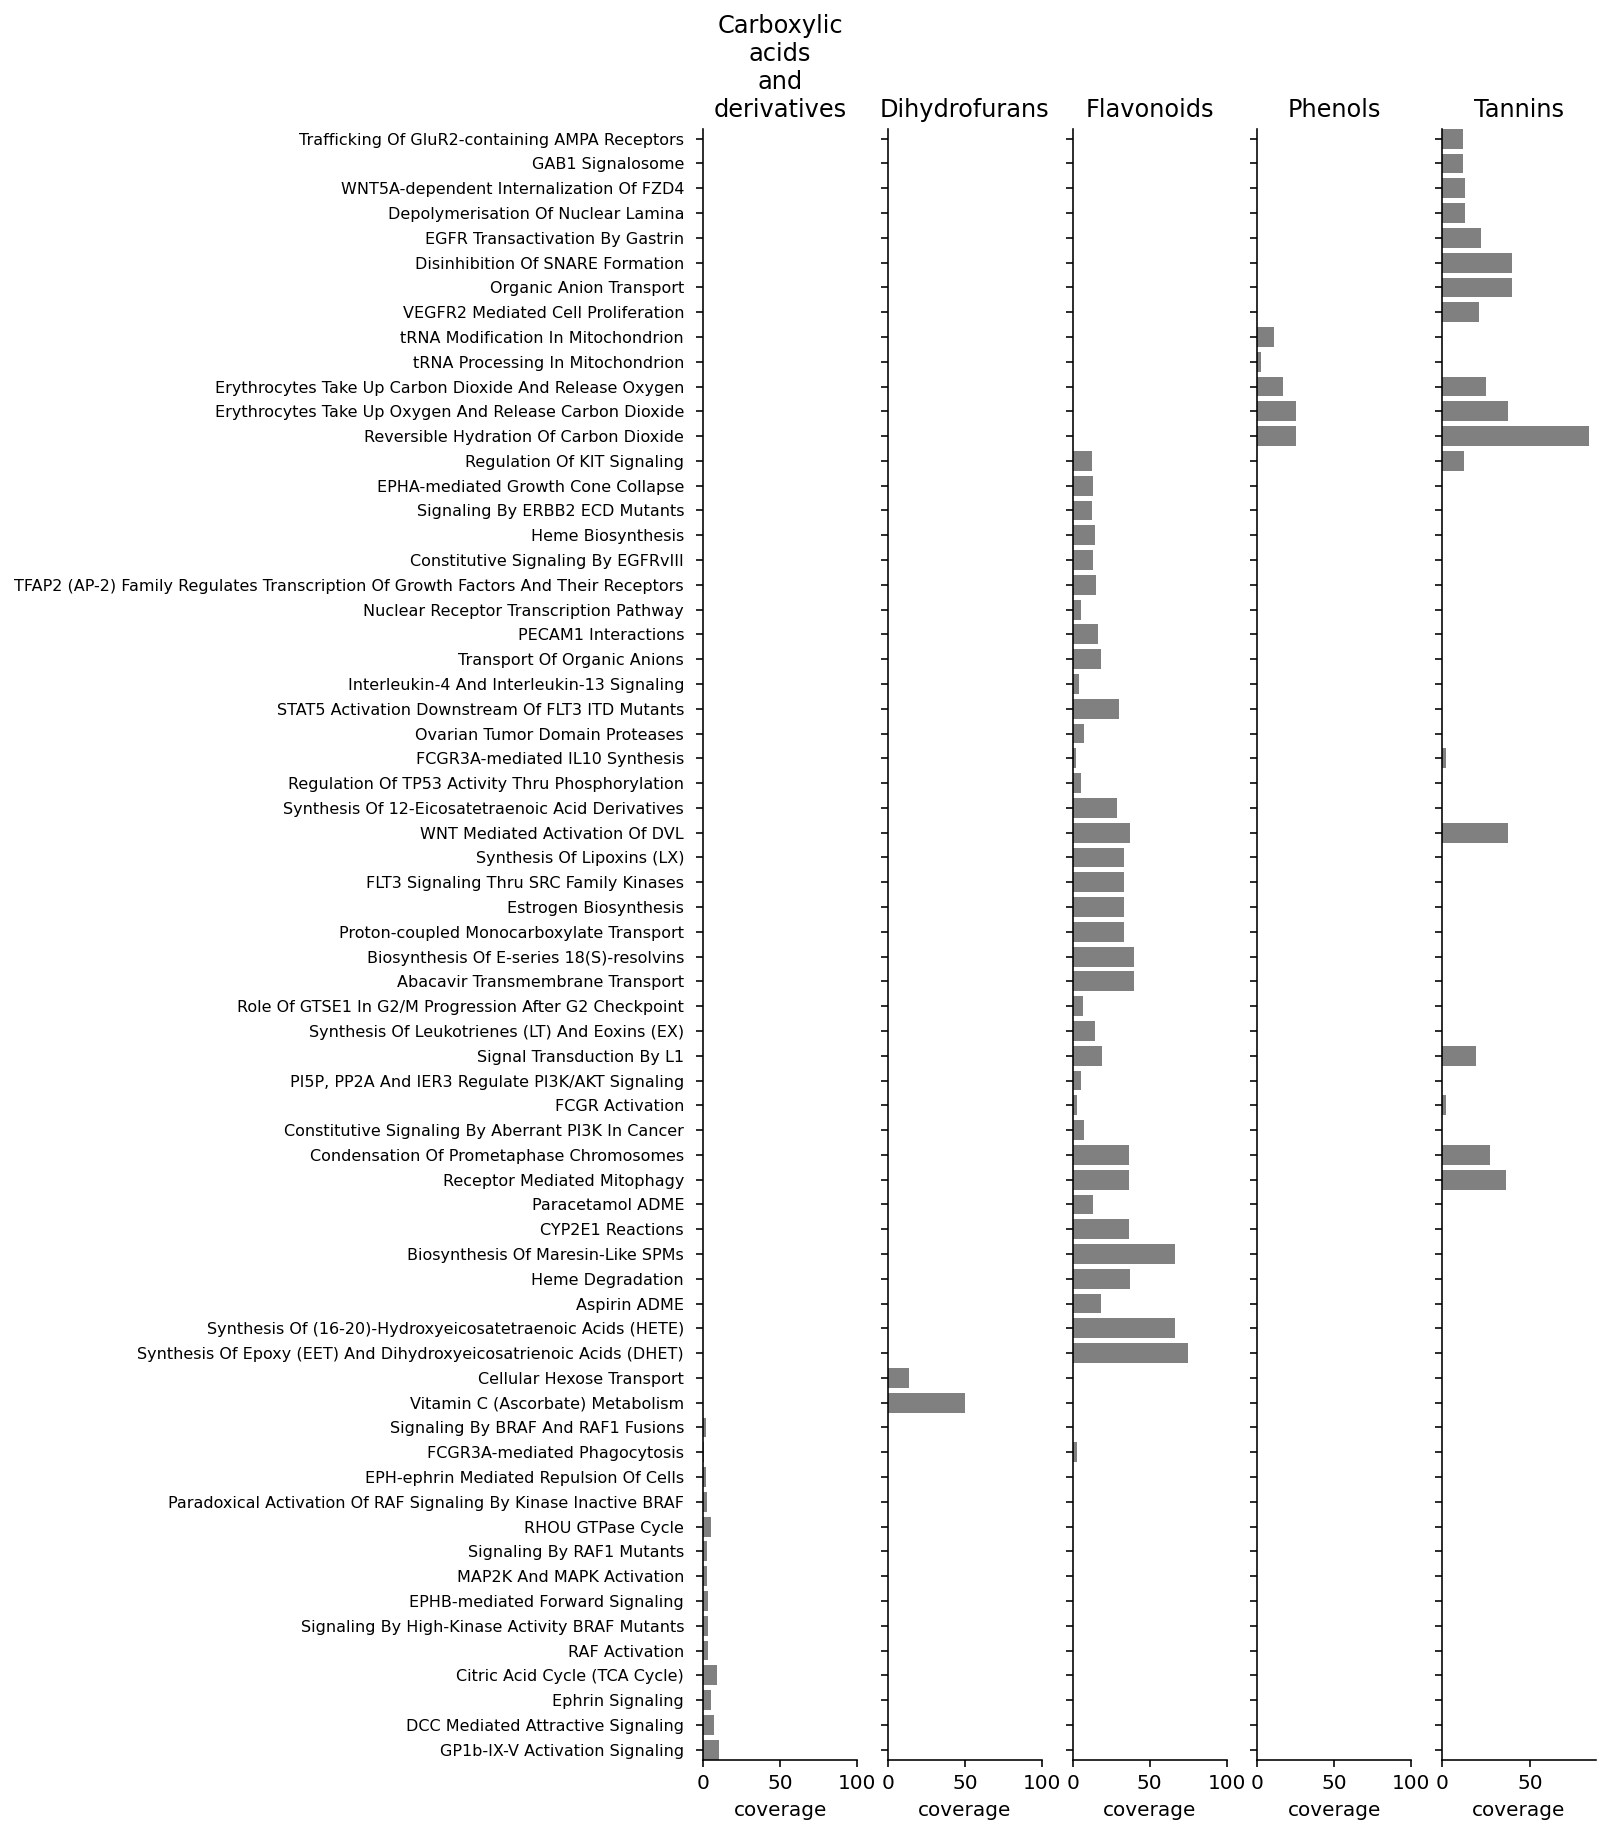

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=path_sel['class'].nunique(), sharey=True, figsize=(8,15))
i = 0
for c in path_sel['class'].unique():
    df = path_sel[path_sel['class'] == c]
    axes[i].barh(df.set_B, df.coverage, color='grey')
    axes[i].set_title('\n'.join(c.split(' ')))
    axes[i].set_xlabel('coverage')
    axes[i].set_xlim(xmin=0, xmax=100)
    plt.setp(axes[i].get_yticklabels(), fontsize=8)
    sns.despine()
    i += 1
plt.margins(y=0)
plt.axis('tight')
#plt.savefig('figures/pathway_enrichment_on_Gooseberry.svg', bbox_inches='tight')